In [4]:
%qtconsole

In [5]:
import pickle
import matplotlib
import pandas as pd
%matplotlib inline

In [6]:
pd=pickle.load(open("pd.pickle","rb"))


Please cite -- HTMD: High-Throughput Molecular Dynamics for Molecular Discovery
J. Chem. Theory Comput., 2016, 12 (4), pp 1845-1852. 
http://pubs.acs.org/doi/abs/10.1021/acs.jctc.6b00049

You are on the latest HTMD version (unpackaged : /home/toni/work/htmd/htmd/htmd).



In [7]:
def get_pka_plot(prepData, pH=7.4, figSize=(15,25)):

    from matplotlib.pyplot import figure, show, cm
    from matplotlib.lines import Line2D
    import numpy as np
    
    # titr =  (~ pd.isnull(d.pKa)) & d.pKa < 99
    d = prepData.data
    titr =  d.pKa < 99  # Automatically excludes NaN
    N = sum(titr)
    
    # Format residue labels
    labels = [x.resname+" "+str(x.resid)+x.insertion for i,x in d.loc[titr].iterrows()]
    pKas = d.pKa.loc[titr]


    # Shading
    C = 19
    X = np.array([range(C),range(C)])
    X = X - (C-1)/2

    xmin, xmax = xlim = 0, 14
    ymin, ymax = ylim = -1, N

    fig = figure(figsize=figSize)
    ax = fig.add_subplot(111, xlim=xlim, ylim=ylim,
                         autoscale_on=False)
    ax.yaxis.set_ticks(range(N))
    ax.yaxis.set_ticklabels(labels)
    ax.invert_yaxis()

    width=.7
    for i in range(N):
        left=xmin
        right=xmax
        top=i+width/2
        bottom=i-width/2
        pk = pKas.iloc[i]
        ax.imshow(X-pk+7,interpolation='bicubic', 
                  cmap=cm.coolwarm, vmin=-7, vmax=7,
                  extent=(left, right, bottom, top), alpha=1)

        ax.add_line(Line2D([pk,pk], [bottom,top], linewidth=3, color='white'))
        ax.text(xmax,i,"{:5.2f} ".format(pk),fontsize=14,color="white",horizontalalignment='right')

    # Vertical line at pH
    ax.axvline(x=pH, linewidth=100, color="k", alpha=.2) 
    ax.axvline(x=pH, linewidth=20, color="k", alpha=.3) 


    ax.set_aspect('auto')
    show()


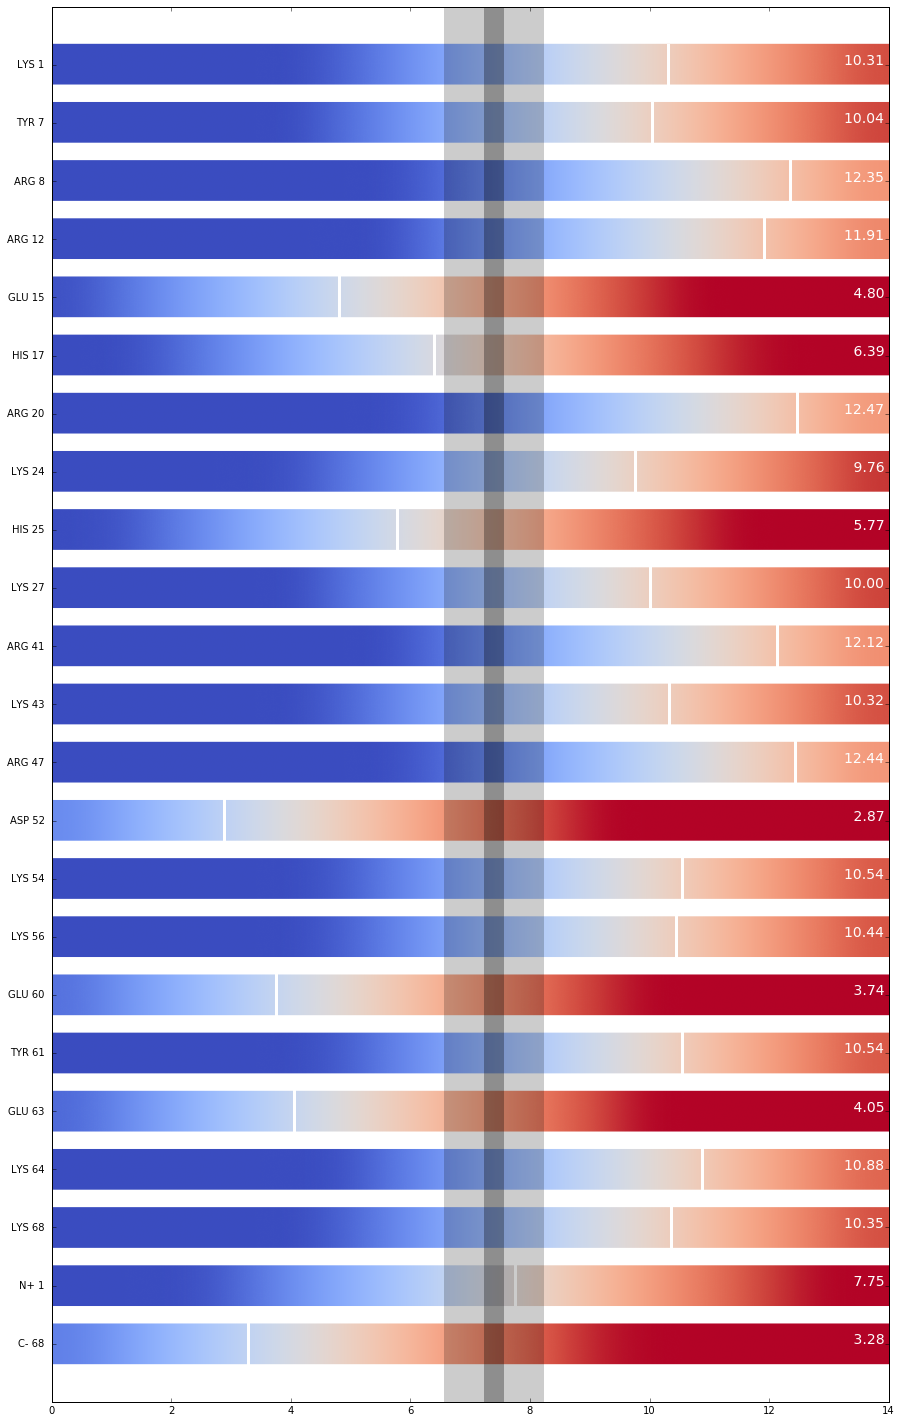

In [8]:
get_pka_plot(pd, pH=7.4)
